### Load and transform datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from torch.utils.data import DataLoader
import os
print(torch.cuda.is_available())
device = torch.device("cpu")   
BATCH_SIZE = 128   
transform=transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) 
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)  

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# Cifar-10 tags for classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



/home/gt/anaconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import numpy as np
def get_mean_std(dataset, ratio=0.01):
    
    dataloader = DataLoader(dataset, batch_size=int(len(dataset)*ratio), 
                                             shuffle=True, num_workers=10)
    train = next(iter(dataloader))[0]   
    mean = np.mean(train.numpy(), axis=(0,2,3))
    std = np.std(train.numpy(), axis=(0,2,3))
    return mean, std

train_mean, train_std = get_mean_std(trainset, 1)

test_mean, test_std = get_mean_std(testset, 1)

print('train_mean:'+str(train_mean))
print('train_std:'+str(train_std))

print('test_mean:'+str(test_mean))
print('test_std:'+str(test_std))

train_mean:[0.49139997 0.4821576  0.44653165]
train_std:[0.24703258 0.24348524 0.26158816]
test_mean:[0.49421406 0.48513097 0.45040995]
test_std:[0.24665284 0.24289232 0.26159248]


For train set, to increase the sample size, perform arbitrary chop after 0 padding and random Flip

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.49139938,0.48215583,0.4465304), (0.24703339, 0.2434853, 0.26158828)), 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4942145, 0.48513037, 0.45040908), (0.24665278, 0.24289253, 0.26159227)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #训练数据集
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)   #生成一个个batch进行批训练，组成batch的时候顺序打乱取

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)



Files already downloaded and verified
Files already downloaded and verified


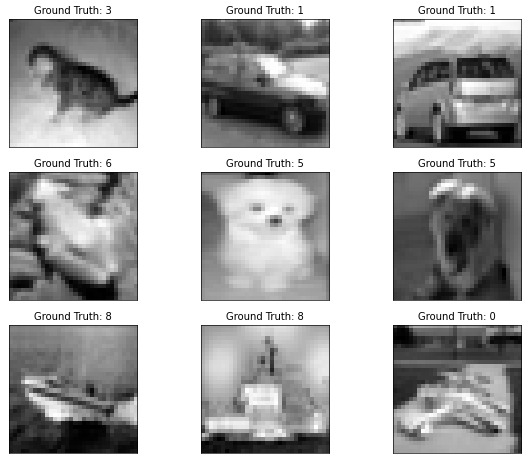

In [5]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_X, example_y) = next(examples)

# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_X[i][0], cmap='gray')
  plt.title("Ground Truth: {}".format(example_y[i]))
  plt.xticks([])
  plt.yticks([])

Define Model- RESNet

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        output = nn.Sequential(self.conv1, self.layer1, self.layer2, self.layer3, self.layer4)(x)
        output = F.avg_pool2d(output, 4)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output


def ResNet18():

    return ResNet(ResidualBlock)


create the model

In [7]:
model = ResNet(ResidualBlock).to(device)
if os.path.exists('./models/RES_model.pkl'):
    model.load_state_dict(state_dict= torch.load('./models/RES_model.pkl'))

Loss function, optimizer

In [8]:
LR = 0.01 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
if os.path.exists('./models/RES_optimizer.pkl'):
    optimizer.load_state_dict(state_dict= torch.load('./models/RES_optimizer.pkl'))

Train the model

In [12]:
EPOCH = 100
PRE_EPOCH = 0  
BEST_ACC = 0

def train(epoch, model:nn.Module, optimizer, data_loader) :
    model.train()
    loss_list = []
    ACC_list = []
    for _ in range(epoch):
        for idx, (input, target) in enumerate(data_loader):
            #cuda
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if idx % 100 == 0:
                #save model
                torch.save(model.state_dict(), './models/RES_model.pkl')
                torch.save(optimizer.state_dict(), './models/RES_optimizer.pkl')
                
                pred = output.argmax(dim=1, keepdim=True)
                ACC = pred.eq(target.view_as(pred)).float().mean()
                if(ACC > BEST_ACC) : torch.save(model.state_dict(), './models/RES_best_model_params.pkl')
                loss_list.append(loss.cpu())
                ACC_list.append(ACC.cpu())
                print('Epoch: %d, idx: %d, loss : %lf, ACC: %lf' %(_, idx, loss.item(), ACC))


loss_list_Train, ACC_list_Train = train(EPOCH, model=model, optimizer= optimizer, data_loader = train_loader)

In [10]:
import numpy as np
def test(model:nn.Module, data_loader):
    model.eval()
    ACC_list = []
    loss_list = []
    pred_list = []
    for idx, (input, target) in enumerate(data_loader):
        with torch.no_grad():
            #cuda
            input, target = input.to(device), target.to(device)
            output = model(input)

            loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            ACC = pred.eq(target.view_as(pred)).float().mean()
            
            ACC_list.append(ACC.cpu())
            loss_list.append(loss.cpu())
            pred_list.extend(pred.cpu().flatten())

    print('average ACC: ',np.mean(ACC_list))
    print('average loss: ',np.mean(loss_list))
    return pred_list, loss_list, ACC_list


In [13]:
from sklearn.metrics import classification_report
model = ResNet(ResidualBlock).to(device)
if os.path.exists('./models/RES_best_model_params.pkl'):
    model.load_state_dict(state_dict= torch.load('./models/RES_best_model_params.pkl'))


y_predicted_cls, loss_list_Test, ACC_list_Test = test(model=model, data_loader=test_loader)
print(len(y_predicted_cls))
y_test = testset.targets

print(classification_report(y_test, y_predicted_cls))

average ACC:  0.890625
average loss:  0.38586622
10000
              precision    recall  f1-score   support

           0       0.11      0.12      0.12      1000
           1       0.09      0.10      0.10      1000
           2       0.12      0.11      0.12      1000
           3       0.11      0.08      0.09      1000
           4       0.09      0.09      0.09      1000
           5       0.10      0.11      0.10      1000
           6       0.10      0.12      0.10      1000
           7       0.10      0.10      0.10      1000
           8       0.10      0.10      0.10      1000
           9       0.10      0.10      0.10      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



1. ### Can neural networks be used for unsupervised clustering or data dimension reduction? Why?

​		都可以应用，对于clustering来说，例如自组织神经网络通过自动寻找样本中的内在规律和本质属性，自组织，自适应地改变网络参数与结构。对于dimension reduction，例如自编码器(encoder decoder)先编码再解码，来构造损失。

2. ### What are the strengths of neural networks; when do they perform well?

​		学习能力强深度学习具备很强的学习能力。

​		覆盖范围广，适应性好深度学习的神经网络层数很多，宽度很广，理论上可以映射到任意函数，所以能解决很复杂的问题。

3. ### What are the weaknesses of neural networks; when do they perform poorly?

​		只能提供有限数据量的应用场景下，深度学习算法不能够对数据的规律进行无偏差的估计。但同时为了达到很好的精度，由于数据量增大深度学习中图模型的复杂化导致算法的时间复杂度急剧提升。

​		把一切问题的特征都变为数字，推理都变为数值计算，造成信息损失。

​		“黑盒”，缺乏可解释性

4. ### What makes neural networks a good candidate for the classification regression problem, if you have enough knowledge about the data?

1.数据量大

2.对于卷积神经网络：特征在空间上有关联有结构。比如说一幅图像，像素和像素排成阵列，是一个平面。特征与特征是同质的。比如图像，像素和像素只是位置上的不同，采样原理是一样的。比如说心电信号这样一个电压信号，是一个信号序列，是同一个采样机制在不同的时刻上采到的信号。